# REFMAP laboratory listening test 1 analysis: Exploratory data analysis — anomaly checking and sample feature analysis

## Setup

In [1]:
# import statements
import sys
import os
import numpy as np
import pandas as pd
from PyQt5.QtWidgets import QFileDialog, QApplication
import matplotlib as mpl
from matplotlib import pyplot as plt


In [2]:
# set plot parameters
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams.update({'font.size': 16})
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['mathtext.fontset'] = 'stix'

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE,
       labelsize=MEDIUM_SIZE)    # fontsize of the axes title and x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mycolours = [(0, 102, 255), (0, 204, 153), (255, 0, 102), (74, 111, 152),
             (251, 164, 49), (204, 153, 255), (90, 192, 255), (80, 245, 233),
             (255, 90, 192), (164, 201, 242), (255, 254, 139), (255, 243, 255)]
mycolours = [tuple(shade/255 for shade in colour) for colour in mycolours]

# enable copy-on-write mode for Pandas (will be default from Pandas 3.0)
pd.options.mode.copy_on_write = True


# check/open QApplication instance
if not QApplication.instance():
    app = QApplication(sys.argv)
else:
    app = QApplication.instance() 


Set this toggle to True if plot saving is desired:

In [3]:
saveplots = True

if saveplots:
    # select figure output save path
    outFigPath = QFileDialog.getExistingDirectory(caption=r"Select output folder to save plots")

    # create subfolders if not already existing
    try:
        os.mkdir(os.path.join(outFigPath, "svg"))
    except FileExistsError:
        pass

    try:
        os.mkdir(os.path.join(outFigPath, "pdf"))
    except FileExistsError:
        pass

## Import data and organise

In [3]:
# import data
fileExts = "*.csv"

# data by stimulus
dataByStimFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_testdata_ByStim.csv",
                                                      caption=r"Open refmap_listest1_testdata_ByStim.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
dataByStimTest = pd.read_csv(dataByStimFilePath, index_col=0)

# Part A data by subject
partADataFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_testdataA_BySubj.csv",
                                                     caption=r"Open refmap_listest1_testdataA_BySubj.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
partADataBySubj = pd.read_csv(partADataFilePath, index_col=False)

# pre and post test data
preTestDataFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_pretestdata.csv",
                                                       caption=r"Open refmap_listest1_pretestdata.csv in: 03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
preTestResponses = pd.read_csv(preTestDataFilePath, index_col=0)
postTestDataFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_posttestdata.csv",
                                                        caption=r"Open refmap_listest1_posttestdata.csv in: 03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
postTestResponses = pd.read_csv(postTestDataFilePath, index_col=0)


FileNotFoundError: [Errno 2] No such file or directory: ''

In [5]:
# categorise columns

for dataset in [dataByStimTest, partADataBySubj]:
    dataset['AmbientEnv'] = pd.Categorical(dataset['AmbientEnv'], ["Park", "Street"], ordered=True)
    dataset['SNRlevel'] = pd.Categorical(dataset['SNRlevel'], ["No UAS", "-16", "-10", "-4", "2", "8"], ordered=True)
    dataset['UASLAeq'] = pd.Categorical(dataset['UASLAeq'], ["No UAS", "42", "48", "54", "60"], ordered=True)
    dataset['UASOperation'] = pd.Categorical(dataset['UASOperation'], ["No UAS", "Flyby", "Landing", "Takeoff"], ordered=True)
    dataset['UASType'] = pd.Categorical(dataset['UASType'], ["No UAS", "H520", "M300", "T150"], ordered=True)


## Exploratory data analysis and checking

In this section, the data is first examined for potential anomalies, as possible indicators that particular participants may not have fully understood instructions, or some other reason.

For examining the response judgements (annoyance, valence, arousal), the analysis comprises calculating the proportion of outlying data points returned by each participant. Outliers are defined here using the Tukey interquartile criterion of 1.5x the interquartile range above or below the top and bottom quartiles.

For the noticeability judgement, a subselection of data is made for (i) zero or very low partial loudness values (< 0.3 sones), and (ii) very high partial loudness values (> 13 sones), and the number of 'suspect false positive' or 'suspect false negative' judgements are counted per participant.

Note that, although judgement data were not collected in Part A for participant 17, that participant had 0 outliers in Part B anyway, so the proportion of outliers would remain 0, even if the lack of Part A judgement data were accounted for - to simplify the code, the correct adjustment has been omitted as it would not change the outcome. There is also no noticeability data entry for participant 17 so this participant has been omitted from the corresponding figure.

In [16]:
# Tukey outlier test
kFact = 1.5  # multiplying factor to identify outliers from IQ range

# Annoyance
AnnoyLowQ = dataByStimTest.loc[:,
                               'Annoyance_1':'Annoyance_19'].quantile(0.25,
                                                                      axis=1).to_frame()
AnnoyHiQ = dataByStimTest.loc[:,
                              'Annoyance_1':'Annoyance_19'].quantile(0.75,
                                                                     axis=1).to_frame()
AnnoyIQ = AnnoyHiQ.values - AnnoyLowQ.values

AnnoyLowOut = AnnoyLowQ.values - kFact*(AnnoyIQ)
AnnoyHiOut = AnnoyHiQ.values + kFact*(AnnoyIQ)

AnnoyOutTest = pd.DataFrame(data=np.logical_or(dataByStimTest.loc[:,
                                                                  'Annoyance_1':'Annoyance_19'].values
                                               < AnnoyLowOut,
                                               dataByStimTest.loc[:,
                                                                  'Annoyance_1':'Annoyance_19'].values
                                               > AnnoyHiOut),
                            index=dataByStimTest.loc[:,
                                                     'Annoyance_1':'Annoyance_19'].index,
                            columns=[participant.replace("Annoyance_", "")
                                     for participant
                                     in dataByStimTest.loc[:,
                                                           'Annoyance_1':'Annoyance_19'].columns])
AnnoyOutTestScore = AnnoyOutTest.sum(axis=0)
AnnoyOutTestScore.index = AnnoyOutTestScore.index.astype(dtype=int,
                                                         copy=False)
AnnoyOutTestScore.sort_index(inplace=True)

# Valence
ValenceLowQ = dataByStimTest.loc[:,
                                 'Valence_1':'Valence_19'].quantile(0.25,
                                                                    axis=1).to_frame()
ValenceHiQ = dataByStimTest.loc[:,
                                'Valence_1':'Valence_19'].quantile(0.75,
                                                                   axis=1).to_frame()
ValenceIQ = ValenceHiQ.values - ValenceLowQ.values

ValenceLowOut = ValenceLowQ.values - kFact*(ValenceIQ)
ValenceHiOut = ValenceHiQ.values + kFact*(ValenceIQ)

ValenceOutTest = pd.DataFrame(data=np.logical_or(dataByStimTest.loc[:,
                                                                    'Valence_1':'Valence_19'].values
                                                 < ValenceLowOut,
                                               dataByStimTest.loc[:,
                                                                  'Valence_1':'Valence_19'].values
                                               > ValenceHiOut),
                            index=dataByStimTest.loc[:,
                                                     'Valence_1':'Valence_19'].index,
                            columns=[participant.replace("Valence_", "") for participant
                                     in dataByStimTest.loc[:,
                                                           'Valence_1':'Valence_19'].columns])
ValenceOutTestScore = ValenceOutTest.sum(axis=0)
ValenceOutTestScore.index = ValenceOutTestScore.index.astype(dtype=int,
                                                             copy=False)
ValenceOutTestScore.sort_index(inplace=True)

# Arousal
ArousalLowQ = dataByStimTest.loc[:,
                               'Arousal_1':'Arousal_19'].quantile(0.25,
                                                                      axis=1).to_frame()
ArousalHiQ = dataByStimTest.loc[:,
                              'Arousal_1':'Arousal_19'].quantile(0.75,
                                                                     axis=1).to_frame()
ArousalIQ = ArousalHiQ.values - ArousalLowQ.values

ArousalLowOut = ArousalLowQ.values - kFact*(ArousalIQ)
ArousalHiOut = ArousalHiQ.values + kFact*(ArousalIQ)

ArousalOutTest = pd.DataFrame(data=np.logical_or(dataByStimTest.loc[:,
                                                                    'Arousal_1':'Arousal_19'].values
                                                 < ArousalLowOut,
                                               dataByStimTest.loc[:,
                                                                  'Arousal_1':'Arousal_19'].values
                                               > ArousalHiOut),
                              index=dataByStimTest.loc[:,
                                                     'Arousal_1':'Arousal_19'].index,
                              columns=[participant.replace("Arousal_", "") for participant
                                       in dataByStimTest.loc[:,
                                                             'Arousal_1':'Arousal_19'].columns])
ArousalOutTestScore = ArousalOutTest.sum(axis=0)
ArousalOutTestScore.index = ArousalOutTestScore.index.astype(dtype=int,
                                                             copy=False)
ArousalOutTestScore.sort_index(inplace=True)

# Total outliers per participant
TotalOutTestScore = AnnoyOutTestScore + ValenceOutTestScore + ArousalOutTestScore

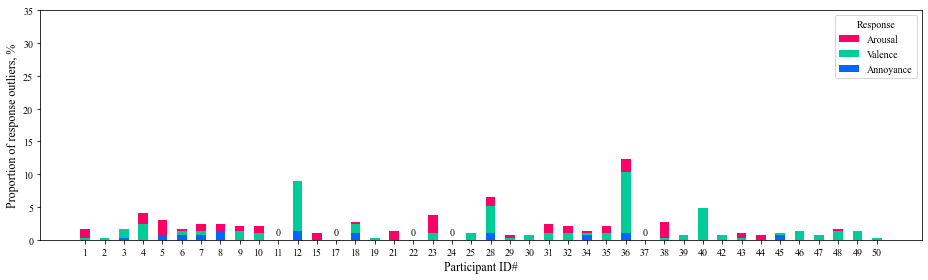

In [25]:
# plot response outliers
fig, ax = plt.subplots(figsize=(13, 4))
OutScoreProps = {"Annoyance": AnnoyOutTestScore/AnnoyOutTest.shape[0],
                 "Valence": ValenceOutTestScore/ValenceOutTest.shape[0],
                 "Arousal": ArousalOutTestScore/ArousalOutTest.shape[0]}
width = 0.5
bottom = np.zeros(ArousalOutTestScore.index.size)

for ii, (responseType, OutScoreProp) in enumerate(OutScoreProps.items()):
    p = ax.bar(OutScoreProp.index.astype(str), 100/3*OutScoreProp, width,
               label=responseType,
               bottom=bottom, color=mycolours[ii])
    bottom += 100/3*OutScoreProp    

TotalOutTestScoreProp = TotalOutTestScore/(AnnoyOutTest.shape[0]
                                           + ValenceOutTest.shape[0]
                                           + ArousalOutTest.shape[0])
barLabels = (100*np.round(TotalOutTestScoreProp, 2)).astype(int).astype(str)
barLabels[TotalOutTestScoreProp != 0] = ""
ax.bar_label(container=p, labels=barLabels, padding =3)


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title="Response")
ax.set(xticks=OutScoreProp.index.astype(str), yticks=range(0, 40, 5), ylabel="Proportion of response outliers, %",
       xlabel="Participant ID#")

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "ResponseOutliersTukey.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "ResponseOutliersTukey.pdf"),
                format='pdf')

plt.show()

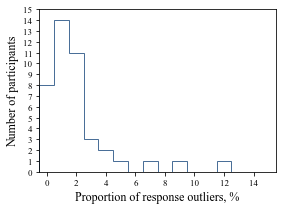

In [54]:

fig, ax = plt.subplots(figsize=(4, 3))

plt.hist(x=TotalOutTestScoreProp*100,
         bins=np.arange(-0.5, 40.5, 1), histtype='step', color=mycolours[3])
ax.set(xticks=range(0, 21, 2), xlim=[-0.5, 15.5], yticks=range(0, 16),
       xlabel="Proportion of response outliers, %", ylabel="Number of participants")
plt.show()

In [14]:
# Tukey outlier test
kFact = 1.5  # multiplying factor to identify outliers from IQ range

# change in annoyance

dAnnoyLowQ = dataByStimTest.loc[:,
                                'dAnnoyance_1':'dAnnoyance_19'].quantile(0.25,
                                                                         axis=1).to_frame()
dAnnoyHiQ = dataByStimTest.loc[:,
                               'dAnnoyance_1':'dAnnoyance_19'].quantile(0.75,
                                                                        axis=1).to_frame()
dAnnoyIQ = dAnnoyHiQ.values - dAnnoyLowQ.values

dAnnoyLowOut = dAnnoyLowQ.values - kFact*(dAnnoyIQ)
dAnnoyHiOut = dAnnoyHiQ.values + kFact*(dAnnoyIQ)

dAnnoyOutTest = pd.DataFrame(data=np.logical_or(dataByStimTest.loc[:,
                                                                   'dAnnoyance_1':'dAnnoyance_19'].values
                                                < dAnnoyLowOut,
                                                dataByStimTest.loc[:,
                                                                   'dAnnoyance_1':'dAnnoyance_19'].values
                                                > dAnnoyHiOut),
                            index=dataByStimTest.loc[:,
                                                     'dAnnoyance_1':'dAnnoyance_19'].index,
                            columns=[participant.replace("dAnnoyance_", "")
                                     for participant
                                     in dataByStimTest.loc[:,
                                                           'dAnnoyance_1':'dAnnoyance_19'].columns])
dAnnoyOutTestScore = dAnnoyOutTest.sum(axis=0)
dAnnoyOutTestScore.index = dAnnoyOutTestScore.index.astype(dtype=int,
                                                           copy=False)
dAnnoyOutTestScore.sort_index(inplace=True)

# Change in valence
dValenceLowQ = dataByStimTest.loc[:,
                                  'dValence_1':'dValence_19'].quantile(0.25,
                                                                       axis=1).to_frame()
dValenceHiQ = dataByStimTest.loc[:,
                                 'dValence_1':'dValence_19'].quantile(0.75,
                                                                      axis=1).to_frame()
dValenceIQ = dValenceHiQ.values - dValenceLowQ.values

dValenceLowOut = dValenceLowQ.values - kFact*(dValenceIQ)
dValenceHiOut = dValenceHiQ.values + kFact*(dValenceIQ)

dValenceOutTest = pd.DataFrame(data=np.logical_or(dataByStimTest.loc[:,
                                                                     'dValence_1':'dValence_19'].values
                                                  < dValenceLowOut,
                                                  dataByStimTest.loc[:,
                                                                     'dValence_1':'dValence_19'].values
                                                  > dValenceHiOut),
                               index=dataByStimTest.loc[:,
                                                        'dValence_1':'dValence_19'].index,
                               columns=[participant.replace("dValence_", "") for participant
                                        in dataByStimTest.loc[:,
                                                              'dValence_1':'dValence_19'].columns])
dValenceOutTestScore = dValenceOutTest.sum(axis=0)
dValenceOutTestScore.index = dValenceOutTestScore.index.astype(dtype=int,
                                                             copy=False)
dValenceOutTestScore.sort_index(inplace=True)

# Change in arousal
dArousalLowQ = dataByStimTest.loc[:,
                                  'dArousal_1':'dArousal_19'].quantile(0.25,
                                                                       axis=1).to_frame()
dArousalHiQ = dataByStimTest.loc[:,
                                 'dArousal_1':'dArousal_19'].quantile(0.75,
                                                                      axis=1).to_frame()
dArousalIQ = dArousalHiQ.values - dArousalLowQ.values

dArousalLowOut = dArousalLowQ.values - kFact*(dArousalIQ)
dArousalHiOut = dArousalHiQ.values + kFact*(dArousalIQ)

dArousalOutTest = pd.DataFrame(data=np.logical_or(dataByStimTest.loc[:,
                                                                     'dArousal_1':'dArousal_19'].values
                                                  < dArousalLowOut,
                                                  dataByStimTest.loc[:,
                                                                     'dArousal_1':'dArousal_19'].values
                                                  > dArousalHiOut),
                               index=dataByStimTest.loc[:,
                                                        'dArousal_1':'dArousal_19'].index,
                               columns=[participant.replace("dArousal_", "") for participant
                                        in dataByStimTest.loc[:,
                                                              'dArousal_1':'dArousal_19'].columns])
dArousalOutTestScore = dArousalOutTest.sum(axis=0)
dArousalOutTestScore.index = dArousalOutTestScore.index.astype(dtype=int,
                                                               copy=False)
dArousalOutTestScore.sort_index(inplace=True)

# Total outliers per participant
dTotalOutTestScore = dAnnoyOutTestScore + dValenceOutTestScore + dArousalOutTestScore

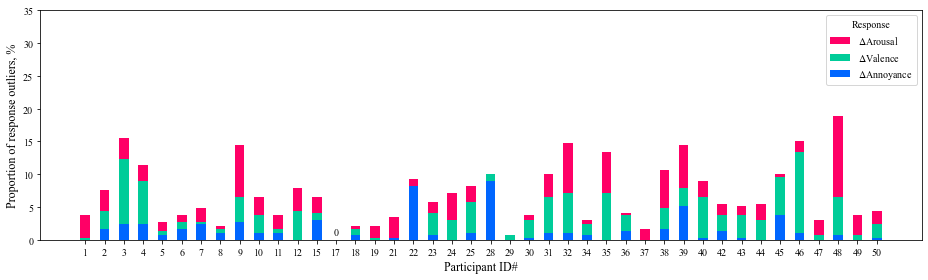

In [15]:
# plot change response outliers
fig, ax = plt.subplots(figsize=(13, 4))
OutScoreProps = {r"$\Delta$Annoyance": dAnnoyOutTestScore/dAnnoyOutTest.shape[0],
                 r"$\Delta$Valence": dValenceOutTestScore/dValenceOutTest.shape[0],
                 r"$\Delta$Arousal": dArousalOutTestScore/dArousalOutTest.shape[0]}
width = 0.5
bottom = np.zeros(dArousalOutTestScore.index.size)

for ii, (responseType, OutScoreProp) in enumerate(OutScoreProps.items()):
    p = ax.bar(OutScoreProp.index.astype(str), 100/3*OutScoreProp, width,
               label=responseType,
               bottom=bottom, color=mycolours[ii])
    bottom += 100/3*OutScoreProp    

dTotalOutTestScoreProp = dTotalOutTestScore/(dAnnoyOutTest.shape[0]
                                             + dValenceOutTest.shape[0]
                                             + dArousalOutTest.shape[0])
barLabels = (100*np.round(dTotalOutTestScoreProp, 2)).astype(int).astype(str)
barLabels[dTotalOutTestScoreProp != 0] = ""
ax.bar_label(container=p, labels=barLabels, padding =3)


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title="Response")
ax.set(xticks=OutScoreProp.index.astype(str), yticks=range(0, 40, 5), ylabel="Proportion of response outliers, %",
       xlabel="Participant ID#")

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "ChangeResponseOutliersTukey.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "ChangeResponseOutliersTukey.pdf"),
                format='pdf')

plt.show()

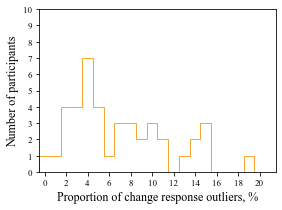

In [59]:

fig, ax = plt.subplots(figsize=(4, 3))

plt.hist(x=dTotalOutTestScoreProp*100,
         bins=np.arange(-0.5, 40.5, 1), histtype='step', color=mycolours[4])
ax.set(xticks=range(0, 21, 2), xlim=[-0.5, 21.5], yticks=range(0, 11),
       xlabel="Proportion of change response outliers, %", ylabel="Number of participants")
plt.show()

The plots indicate that the proportion of outlying responses was typically no more than around 5%, with the exceptions of participants 12, 36 and 40. For these participants, the largest proportion of outliers was attributable to valence responses. Based on this analysis, none of the participants are excluded from further response analyses.

In [74]:
# Noticeability
subdata = partADataBySubj.loc[:, ['ID#', 'UAS_noticed',
                                  'UASPartLoudGMSTPowAvg']]
allIDs = subdata['ID#'].unique()
noticeCheck = pd.DataFrame(index=allIDs, columns=["loCount", "loTot",
                                                  "hiCount", "hiTot"])
for ID in allIDs:
    noticeCheck.loc[ID, 'loCount'] = subdata.loc[subdata['ID#']
                                                 == ID].loc[subdata['UASPartLoudGMSTPowAvg']
                                                            < 0.3].loc[:,
                                                                        'UAS_noticed'].sum()
    noticeCheck.loc[ID, 'loTot'] = np.size(subdata.loc[subdata['ID#']
                                                       == ID].loc[subdata['UASPartLoudGMSTPowAvg']
                                                                  < 0.3].loc[:, 'UAS_noticed'])
    noticeCheck.loc[ID, 'hiCount'] = (subdata.loc[subdata['ID#']
                                                  == ID].loc[subdata['UASPartLoudGMSTPowAvg']
                                                             > 13].loc[:, 'UAS_noticed'] == 0).sum()
    noticeCheck.loc[ID, 'hiTot'] = np.size(subdata.loc[subdata['ID#']
                                                       == ID].loc[subdata['UASPartLoudGMSTPowAvg']
                                                                  > 13].loc[:, 'UAS_noticed'])

noticeCheck['lohiCount'] = noticeCheck['loCount'] + noticeCheck['hiCount']
noticeCheck['lohiTot'] = noticeCheck['loTot'] + noticeCheck['hiTot']
noticeCheck['loProp'] = 100*noticeCheck['loCount'] / noticeCheck['loTot']
noticeCheck['hiProp'] = 100*noticeCheck['hiCount'] / noticeCheck['hiTot']


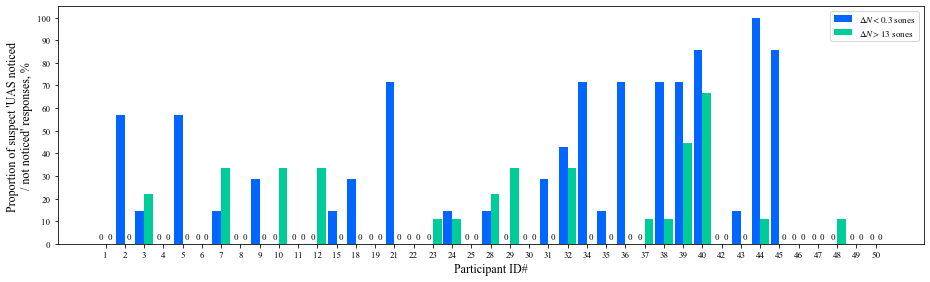

In [11]:
fig, ax = plt.subplots(figsize=(13, 4))

x = np.arange(len(noticeCheck.index))  # the label locations
width = 0.45  # the width of the bars
multiplier = 0

labels = ["$\\Delta N < 0.3$ sones", "$\\Delta N > 13$ sones"]
for ii, lohi in enumerate(noticeCheck[['loProp', 'hiProp']].columns):
    offset = width * multiplier
    rects = ax.bar(x + offset, noticeCheck[lohi], width, label=labels[ii],
                   color=mycolours[ii])
    barLabels = np.array([round(value) for value in rects.datavalues], dtype=str)
    barLabels[barLabels != "0"] = ""
    ax.bar_label(container=rects, labels=barLabels, padding=3)
    multiplier += 1

ax.set(xticks=np.arange(len(noticeCheck.index)) + width/2,
       xticklabels=noticeCheck.index.astype(str), yticks=range(0, 110, 10),
       ylabel="Proportion of suspect 'UAS noticed " + "\n" + "/ not noticed' responses, %",
       xlabel="Participant ID#")
ax.legend()
plt.savefig(os.path.join(outFigPath, "NoticeabilityAnomalies.svg"),
            format='svg')
plt.show()

The plot indicates that 'suspect false positives' and 'suspect false negatives' were typically no more than around 30%, with the exception of participants 2, 5, 21, 32, 34, 36, 38, 39, 40, 44 and 45. The relatively large proportions of suspect data for these participants suggests either that they identified a sound in the stimuli they thought was an aircraft even when the UAS sound was absent or unlikely to be audible (false positive), or they forgot/didn't bother to continue checking the boxes (either 'other' or 'aircraft') when they had heard the UAS sound at high audibility (false negative). All these participants indicated a 'noticed' judgement for at least one of the 'no UAS' stimuli, which underlines the unreliability of the data.

These participants are subsequently excluded from further noticeability analysis (but retained for response analysis). Omitting these 11 participants from the sample of 41 leaves 30 participants for noticeability analyses.

## Sample feature data

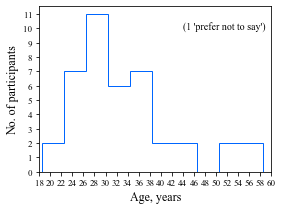

In [14]:
# age distribution
fig, ax = plt.subplots(figsize=(4, 3))

nullResponse = (postTestResponses.Age == "No answer").sum()
nonnullResponse = (postTestResponses.Age != "No answer").sum()

plt.hist(x=postTestResponses.Age[postTestResponses.Age != "No answer"].astype(int),
         bins=np.arange(18.5, 62.5, 4), histtype='step', color=mycolours[0])
ax.set(xticks=range(18, 62, 2), xlim=[18, 60], yticks=range(0, 12),
       xlabel="Age, years", ylabel="No. of participants")

ax.text(x=44, y=10, s="(" + str(nullResponse) + " 'prefer not to say')", fontsize=10)
plt.savefig(os.path.join(outFigPath, "SampleAge.svg"),
            format='svg')
plt.show()


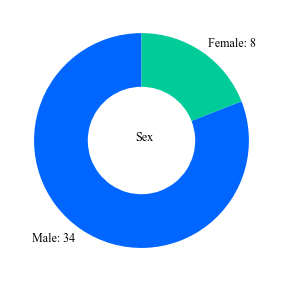

In [12]:
# Sex

sizes = postTestResponses['Sex'].value_counts().values
labels = postTestResponses['Sex'].value_counts().index + ": " +  sizes.astype(str)

fig, ax = plt.subplots(figsize=(4, 4))
ax.pie(sizes, labels=labels, wedgeprops=dict(width=0.5), startangle=90,
       colors=mycolours, textprops={'fontsize': 12})
ax.text(x=-0.06, y=0, s="Sex", fontsize=12)
plt.savefig(os.path.join(outFigPath, "SampleSex.svg"),
            format='svg')
plt.show()

The age distribution plot indicates that a reasonable spread of ages was achieved, with a right skewed normal distribution, as would be expected for bounding the experiment at 18+ years.

The sex chart shows that the sample was overwhelmingly male.

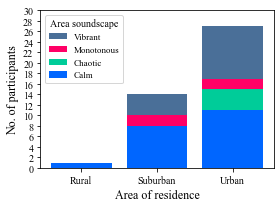

In [12]:
# residential area
fig, ax = plt.subplots(figsize=(4, 3))

areaCats = np.sort(postTestResponses['Home_Area'].unique())
data = postTestResponses[['Home_Area']
                         + ['Area_soundscape']].apply('.'.join,
                                                      axis=1).value_counts().sort_index()
scapeCounts = {"Calm": np.array([1, 8, 11]),
               "Chaotic": np.array([0, 0, 4]),
               "Monotonous": np.array([0, 2, 2]),
               "Vibrant": np.array([0, 4, 10])}

width = 0.5

bottom = np.zeros(3)

for ii, (boolean, scapeCount) in enumerate(scapeCounts.items()):
    p = ax.bar(areaCats, scapeCount,
               label=boolean, bottom=bottom, color=mycolours[ii])
    bottom += scapeCount

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc="upper left", title="Area soundscape", fontsize=9)
ax.set(yticks=range(0, 32, 2), ylabel="No. of participants",
       xlabel="Area of residence")

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "SampleAreas.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "SampleAreas.pdf"),
                format='pdf')

plt.show()


The area of residence plot indicates the majority of participants live in urban areas, which is expected given the location of the experiment.

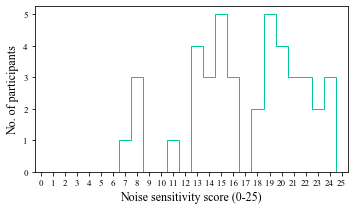

In [8]:
# noise sensitivity distribution
fig, ax = plt.subplots(figsize=(5, 3))

NSSnorm = 5  # normalisation constant to reduce all scores to 0-5 scale

plt.hist(x=postTestResponses.NSSTotal - NSSnorm, bins=np.arange(4.5 - NSSnorm, 30.5 - NSSnorm, 1),
         histtype='step', color=mycolours[1])
ax.set(xticks=range(0, 26, 1), xlim=[-0.5, 25.5], yticks=range(0, 6),
       xlabel="Noise sensitivity score (0-25)", ylabel="No. of participants")
plt.savefig(os.path.join(outFigPath, "SampleNSS.svg"),
            format='svg')
plt.show()


The NSS-SF distribution indicates that the sample had a reasonable spread of noise sensitivities, tending towards the upper range of the scores. The recorded NSS-SF scores have been adjusted down to a range of 0-25, rather than the 5-30 in the original scale.

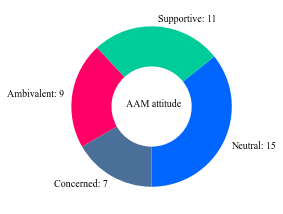

In [19]:
# AAM attitude

sizes = postTestResponses['AAM_attitude'].value_counts().values
labels = postTestResponses['AAM_attitude'].value_counts().index + ": " +  sizes.astype(str)

fig, ax = plt.subplots(figsize=(4, 4))
ax.pie(sizes, labels=labels, wedgeprops=dict(width=0.5), startangle=-90,
       colors=mycolours, textprops={'fontsize': 10})
ax.text(x=-0.32, y=0, s="AAM attitude", fontsize=10)
plt.savefig(os.path.join(outFigPath, "SampleAttitude.svg"),
            format='svg')
plt.show()


The AAM attitude chart shows a reasonable spread of attitudes towards AAM, with a majority 'neutral'.

This is the PANAS (the original scale is 1-5, but it was adapated to allow participants to mark words 'not understood' as 0. This results in a 0-50 scale.

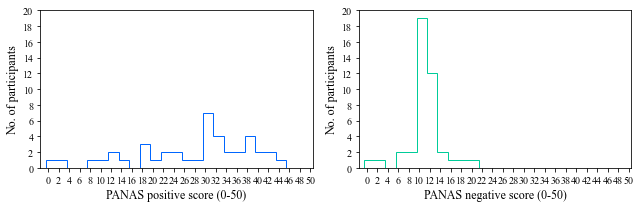

In [160]:
# PANAS score distribution
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))

PANASnorm = 0  # normalisation constant to reduce all scores to 0-4 scale

axs[0].hist(x=preTestResponses['PANAS_positive'] - PANASnorm, bins=np.arange(-2.5 - PANASnorm, 50.5 - PANASnorm, 2),
            histtype='step', color=mycolours[0])
axs[0].set(xticks=range(0, 51, 2), xlim=[-1.5, 50.5], yticks=range(0, 22, 2), ylim=[0, 20],
       xlabel="PANAS positive score (0-50)", ylabel="No. of participants")
axs[1].hist(x=preTestResponses['PANAS_negative'] - PANASnorm, bins=np.arange(-2.5 - PANASnorm, 50.5 - PANASnorm, 2),
            histtype='step', color=mycolours[1])
axs[1].set(xticks=range(0, 51, 2), xlim=[-1.5, 50.5], yticks=range(0, 22, 2), ylim=[0, 20],
       xlabel="PANAS negative score (0-50)", ylabel="No. of participants")

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "SamplePANAS.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "SamplePANAS.pdf"),
                format='pdf')
plt.show()

The PANAS scores indicate a wide spread on the positive affect scale, but mostly low scores on the negative affect scale. This suggests the participants did not have strong negative emotions at the time of commencing the test, and some felt very little positive or negative emotion at all.

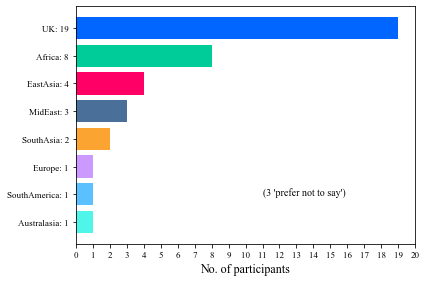

In [30]:
# Nationality region

sizes = postTestResponses['NationGeo'].value_counts().values
sizes = np.sort(sizes)
labels = postTestResponses['NationGeo'].value_counts().index[::-1] + ": " +  sizes.astype(str)
nullResponse = postTestResponses['NationGeo'].isna().sum()

fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(width=sizes, y=labels, color=mycolours[7::-1])
ax.set(xticks=range(0, 21), xlabel="No. of participants")
ax.text(x=11, y=1, s="(" + str(nullResponse) + " 'prefer not to say')", fontsize=10)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "NationGeo.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "NationGeo.pdf"),
                format='pdf')
plt.show()


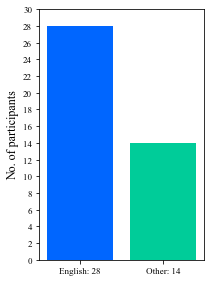

In [8]:
# Native language

sizes = postTestResponses['NativeLang'].value_counts().values
labels = postTestResponses['NativeLang'].value_counts().index + ": " +  sizes.astype(str)

fig, ax = plt.subplots(figsize=(3, 4))
ax.bar(height=sizes, x=labels, color=mycolours)
ax.set(yticks=range(0, 32, 2), ylabel="No. of participants")

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "NativeLang.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "NativeLang.pdf"),
                format='pdf')
plt.show()


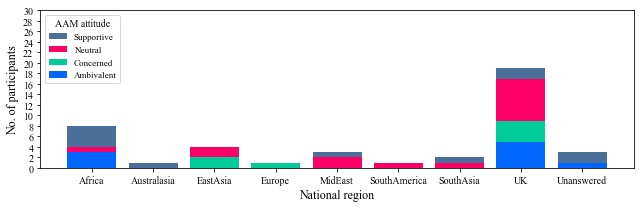

In [10]:
# attitude by national region
fig, ax = plt.subplots(figsize=(9, 3))

postTestResponses.loc[postTestResponses['NationGeo'].isna(), 'NationGeo'] = "Unanswered"
natCats = np.sort(postTestResponses['NationGeo'].unique())
attCats = np.sort(postTestResponses['AAM_attitude'].unique())
data = postTestResponses[['NationGeo']
                         + ['AAM_attitude']].apply('.'.join,
                                                      axis=1).value_counts().sort_index()

df = pd.DataFrame(columns = ['NationGeo', 'AAM_attitude', 'counts'], dtype='int64')
df.NationGeo = natCats.repeat(4, 0)
df.AAM_attitude = np.tile(attCats, len(natCats))
df.counts = 0

for nat in natCats:
    for att in attCats:
        try:
            df.loc[(df['NationGeo'] == nat) & (df['AAM_attitude'] == att), 'counts'] = data.filter(like=nat).filter(like=att).iloc[0]
        except:
            continue

width = 0.5

bottom = np.zeros(len(natCats))

for ii, att in enumerate(attCats):
    p = ax.bar(natCats, df.loc[df['AAM_attitude'] == att, ['NationGeo', 'counts']].counts,
               label=att, bottom=bottom, color=mycolours[ii])
    bottom += np.array(df.loc[df['AAM_attitude'] == att, ['NationGeo', 'counts']].counts)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', title="AAM attitude", fontsize=9)
ax.set(yticks=range(0, 32, 2), ylabel="No. of participants",
       xlabel="National region")

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "NationAttitude.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "NationAttitude.pdf"),
                format='pdf')
plt.show()

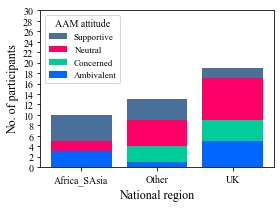

In [9]:
# attitude by national region (grouped)
fig, ax = plt.subplots(figsize=(4, 3))

postTestResponses.loc[postTestResponses['NationGeo'].isna(), 'NationGeo'] = "Unanswered"

postTestResponses['NationGeo3'] = postTestResponses['NationGeo']
postTestResponses.loc[(postTestResponses['NationGeo'] == 'Africa')
                      | (postTestResponses['NationGeo'] == 'SouthAsia'), 'NationGeo3'] = "Africa_SAsia"
postTestResponses.loc[(postTestResponses['NationGeo3'] != 'Africa_SAsia')
                      & (postTestResponses['NationGeo3'] != 'UK'), 'NationGeo3'] = "Other"

natCats = np.array(['Africa_SAsia', 'Other', 'UK'])
attCats = np.sort(postTestResponses['AAM_attitude'].unique())
data = postTestResponses[['NationGeo3']
                         + ['AAM_attitude']].apply('.'.join,
                                                      axis=1).value_counts().sort_index()

df = pd.DataFrame(columns = ['NationGeo3', 'AAM_attitude', 'counts'], dtype='int64')
df.NationGeo3 = natCats.repeat(4, 0)
df.AAM_attitude = np.tile(attCats, len(natCats))
df.counts = 0

for nat in natCats:
    for att in attCats:
        try:
            df.loc[(df['NationGeo3'] == nat)
                   & (df['AAM_attitude'] == att), 'counts'] = data.filter(like=nat).filter(like=att).iloc[0]
        except:
            continue

width = 0.5

bottom = np.zeros(len(natCats))

for ii, att in enumerate(attCats):
    p = ax.bar(natCats, df.loc[df['AAM_attitude'] == att, ['NationGeo3', 'counts']].counts,
               label=att, bottom=bottom, color=mycolours[ii])
    bottom += np.array(df.loc[df['AAM_attitude'] == att, ['NationGeo3', 'counts']].counts)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', title="AAM attitude", fontsize=9)
ax.set(yticks=range(0, 32, 2), ylabel="No. of participants",
       xlabel="National region")

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "NationAttitudeGroup3.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "NationAttitudeGroup3.pdf"),
                format='pdf')
plt.show()

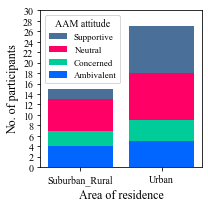

In [8]:
# attitude by home area (grouped)
fig, ax = plt.subplots(figsize=(3, 3))

#postTestResponses.loc[postTestResponses['NationGeo'].isna(), 'NationGeo'] = "Unanswered"

postTestResponses['Home_Area2'] = postTestResponses['Home_Area']
postTestResponses.loc[(postTestResponses['Home_Area2'] == 'Suburban')
                      | (postTestResponses['Home_Area2'] == 'Rural'), 'Home_Area2'] = "Suburban_Rural"

homeCats = np.array(['Suburban_Rural', 'Urban'])
attCats = np.sort(postTestResponses['AAM_attitude'].unique())
data = postTestResponses[['Home_Area2']
                         + ['AAM_attitude']].apply('.'.join,
                                                      axis=1).value_counts().sort_index()

df = pd.DataFrame(columns = ['Home_Area2', 'AAM_attitude', 'counts'], dtype='int64')
df.Home_Area2 = homeCats.repeat(4, 0)
df.AAM_attitude = np.tile(attCats, len(homeCats))
df.counts = 0

for home in homeCats:
    for att in attCats:
        try:
            df.loc[(df['Home_Area2'] == home)
                   & (df['AAM_attitude'] == att), 'counts'] = data.filter(like=home).filter(like=att).iloc[0]
        except:
            continue

width = 0.5

bottom = np.zeros(len(homeCats))

for ii, att in enumerate(attCats):
    p = ax.bar(homeCats, df.loc[df['AAM_attitude'] == att, ['Home_Area2', 'counts']].counts,
               label=att, bottom=bottom, color=mycolours[ii])
    bottom += np.array(df.loc[df['AAM_attitude'] == att, ['Home_Area2', 'counts']].counts)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', title="AAM attitude", fontsize=9)
ax.set(yticks=range(0, 32, 2), ylabel="No. of participants",
       xlabel="Area of residence")

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "AoRAttitudeGroup2.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "AoRAttitudeGroup2.pdf"),
                format='pdf')
plt.show()